In [1]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.interpolate import CubicSpline

# Local imports
from lammps_implicit_der import LammpsImplicitDer, SNAP
from lammps_implicit_der.tools import mpi_print, initialize_mpi, TimingGroup, plot_tools, \
                                      compute_energy_volume, create_perturbed_system, run_npt_implicit_derivative
from lammps_implicit_der.systems import BccSIAancy, Bcc, BccSIA
#from lammps_implicit_der.tools.error_tools import coord_error

plotparams = plot_tools.plotparams.copy()
plotparams['figure.figsize'] = (9, 6)
plotparams['font.size'] = 16
plotparams['figure.subplot.wspace'] = 0.2
plt.rcParams.update(plotparams)

In [28]:
ncell_x = 2
alat = 3.18427
#alat_SIA = 3.18427
alat_SIA = 3.269

bcc_pure0 = Bcc(alat=alat, ncell_x=ncell_x, minimize=False, logname='bcc.log',
               data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

bcc_SIA0 = BccSIA(alat=alat, ncell_x=ncell_x, minimize=False, logname='bcc_SIA.log',
                     data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

print(f'{bcc_pure0.Natom=}')
print(f'{bcc_pure0.energy=:.3f}')
print(f'{bcc_SIA0.Natom=}')
print(f'{bcc_SIA0.energy=:.3f}')

bcc_pure0.Natom=16
bcc_pure0.energy=70.869
bcc_SIA0.Natom=17
bcc_SIA0.energy=116.644


# Positions wihtout minimization

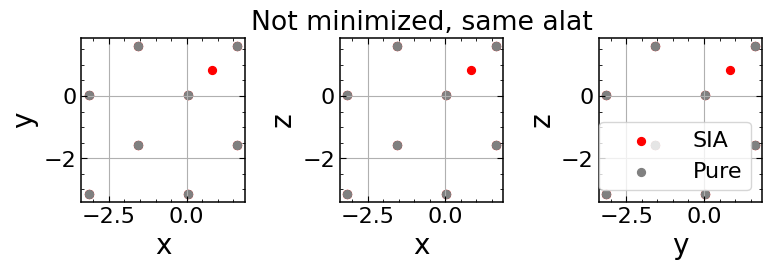

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
plot_tools.plot_coords(axes, bcc_SIA0.X_coord.reshape(-1, 3), c='red', s=32, label='SIA')
plot_tools.plot_coords(axes, bcc_pure0.X_coord.reshape(-1, 3), c='gray', s=32, label='Pure')
for ax in axes:
    ax.grid()
axes[1].set_title('Not minimized, same alat')
plt.tight_layout()

In [19]:
# SIA atom
v1 = np.array([0.8279102,  0.8279102,  0.8279102])
# Central atom
v2 = np.array([0.0318427,  0.0318427 , 0.0318427])
print(f'{np.linalg.norm(v1 - v2) = }')
# From geometry
print(f'{3**0.5 / 4.0 * alat_SIA = }')

np.linalg.norm(v1 - v2) = 1.3788293562543372
3**0.5 / 4.0 * alat_SIA = 1.3788293562543372


# Positions with minimization

In [30]:
bcc_pure = Bcc(alat=alat, ncell_x=ncell_x, minimize=True, logname='bcc.log',
               data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

bcc_SIA = BccSIA(alat=alat_SIA, ncell_x=ncell_x, minimize=True, logname='bcc_SIA.log',
                     data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

print(f'{bcc_pure.Natom=}')
print(f'{bcc_pure.energy=:.3f}')
print(f'{bcc_SIA.Natom=}')
print(f'{bcc_SIA.energy=:.3f}')

bcc_pure.Natom=16
bcc_pure.energy=70.869
bcc_SIA.Natom=17
bcc_SIA.energy=85.656


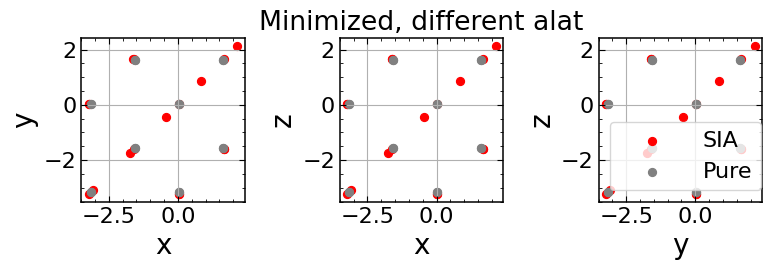

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
plot_tools.plot_coords(axes, bcc_SIA.X_coord.reshape(-1, 3), c='red', s=32, label='SIA')
plot_tools.plot_coords(axes, bcc_pure.X_coord.reshape(-1, 3), c='gray', s=32, label='Pure')
for ax in axes:
    ax.grid()
axes[1].set_title('Minimized, different alat')
plt.tight_layout()

## Energy-volume curve

In [32]:
epsilon_array = np.linspace(-0.05, 0.05, 61)
bcc_pure_tmp = Bcc(alat=alat, ncell_x=ncell_x, minimize=True, logname='bcc.log',
               data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

bcc_SIA_tmp = BccSIA(alat=alat_SIA, ncell_x=ncell_x, minimize=True, logname='bcc_SIA.log',
                     data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

energy_array_pure, volume_array_pure, virial_array_pure, pressure_array_pure = compute_energy_volume(bcc_pure_tmp, epsilon_array)
energy_array_SIA, volume_array_SIA, virial_array_SIA, pressure_array_SIA = compute_energy_volume(bcc_SIA_tmp, epsilon_array)

In [33]:
def get_min(energy_array, volume_array, pressure_array, ncell_x):
    min_idx = np.argmin(energy_array)

    energy_min = energy_array[min_idx]
    volume_min = volume_array[min_idx]
    pressure_min = pressure_array[min_idx]

    alat_min = volume_min**(1/3) / ncell_x

    return energy_min, volume_min, pressure_min, alat_min

energy_pure_min, volume_pure_min, pressure_pure_min, alat_pure_min = \
    get_min(energy_array_pure, volume_array_pure, pressure_array_pure, ncell_x)

print('Pure bcc:')
print(f'{energy_pure_min=:.3f}')
print(f'{volume_pure_min=:.3f}')
print(f'{pressure_pure_min=:.3f}')
print(f'{alat_pure_min=:.3f}')
print('')

energy_SIA_min, volume_SIA_min, pressure_SIA_min, alat_SIA_min = \
    get_min(energy_array_SIA, volume_array_SIA, pressure_array_SIA, ncell_x)

print('SIA bcc:')
print(f'{energy_SIA_min=:.3f}')
print(f'{volume_SIA_min=:.3f}')
print(f'{pressure_SIA_min=:.3f}')
print(f'{alat_SIA_min=:.3f}')


Pure bcc:
energy_pure_min=0.000
volume_pure_min=258.297
pressure_pure_min=-0.003
alat_pure_min=3.184

SIA bcc:
energy_SIA_min=0.000
volume_SIA_min=279.470
pressure_SIA_min=-0.594
alat_SIA_min=3.269


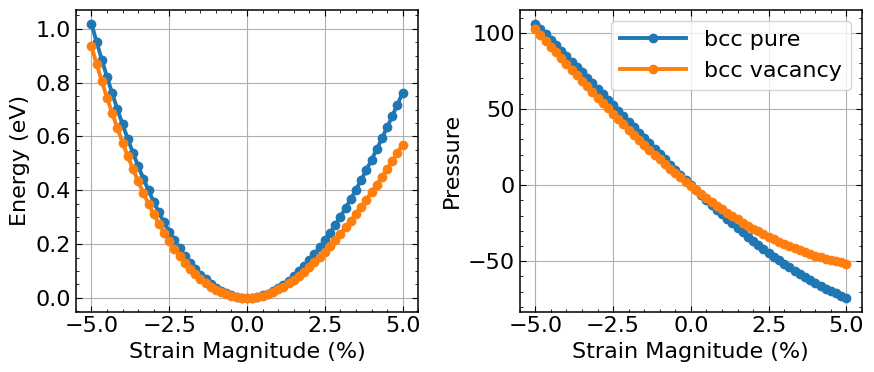

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

ms = 6
axes[0].plot(100.0 * epsilon_array, energy_array_pure, label='bcc pure', ls='-', marker='o', ms=ms)
axes[0].plot(100.0 * epsilon_array, energy_array_SIA, label='bcc SIA', ls='-', marker='o', ms=ms)
axes[0].set_xlabel('Strain Magnitude (%)')
axes[0].set_ylabel('Energy (eV)')

axes[1].plot(100.0 * epsilon_array, pressure_array_pure, label='bcc pure', ls='-', marker='o', ms=ms)
axes[1].plot(100.0 * epsilon_array, pressure_array_SIA, label='bcc SIA', ls='-', marker='o', ms=ms)
axes[1].set_xlabel('Strain Magnitude (%)')
axes[1].set_ylabel('Pressure')
axes[1].legend()

for ax in axes:
    ax.grid()

plt.tight_layout()
plt.show()

# Full minimization with `fix box/relax`

In [44]:
bcc_SIA_box_relax = BccSIA(alat=alat_SIA, ncell_x=ncell_x, minimize=True, logname='bcc_SIA.log',
                           data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False, fix_box_relax=True)

In [47]:
print(f'{bcc_SIA_box_relax.volume}')
print(f'{bcc_SIA_box_relax.volume ** (1/3) / ncell_x}')
print(f'{bcc_SIA_box_relax.energy=:.3f}')
print(f'{bcc_SIA.energy=:.3f}')

279.16231531955214
3.267801001549268
bcc_SIA_box_relax.energy=85.655
bcc_SIA.energy=85.656


## Interpolation of virial and its derivative

In [37]:
spline_list_pure = []
spline_list_SIA = []

for idesc in range(bcc_pure.Ndesc):

    virial_trace_array_pure = np.sum(virial_array_pure[:, :3, :], axis=1) / 3.0
    spline_list_pure.append(CubicSpline(volume_array_pure, virial_trace_array_pure[:, idesc]))

    virial_trace_array_SIA = np.sum(virial_array_SIA[:, :3, :], axis=1) / 3.0
    spline_list_SIA.append(CubicSpline(volume_array_SIA, virial_trace_array_SIA[:, idesc]))

virial_der_pure0 = np.array([spline_list_pure[idesc](volume_pure_min, nu=1) for idesc in range(bcc_pure.Ndesc)])
virial_der_SIA0 = np.array([spline_list_SIA[idesc](volume_SIA_min, nu=1) for idesc in range(bcc_SIA.Ndesc)])

# Perturb parameters and compute formation volumes and energies

### Implicit derivative - inhomogeneous contribution

In [42]:
# Re-define the same systems
bcc_pure = Bcc(alat=alat, ncell_x=ncell_x, minimize=True, logname='bcc.log',
               data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

bcc_SIA = BccSIA(alat=alat_SIA, ncell_x=ncell_x, minimize=True, logname='bcc_SIA.log',
                     data_path = '../lammps_implicit_der/data_files/', snapcoeff_filename = 'W_NEW.snapcoeff', verbose=False)

dX_dTheta_pure_inhom = bcc_pure.implicit_derivative(method='inverse')
dX_dTheta_SIA_inhom = bcc_SIA.implicit_derivative(method='inverse')

bcc_pure.compute_virial()
bcc_pure.gather_virial()
virial_pure = np.sum(bcc_pure.virial, axis=0)
virial_trace_pure = np.sum(virial_pure[:3, :], axis=0) / 3.0

bcc_SIA.compute_virial()
bcc_SIA.gather_virial()
virial_SIA = np.sum(bcc_SIA.virial, axis=0)
virial_trace_SIA = np.sum(virial_SIA[:3, :], axis=0) / 3.0

### Ensemble of Tungsten potentials

In [39]:
path = '../lammps_implicit_der/data_files/'
filename = 'Theta_ens.pkl'
with open(os.path.join(path, filename), 'rb') as file:
    Theta_ens = pickle.load(file)

In [54]:
sample = 1
data_path = '../lammps_implicit_der/data_files/'
snapcoeff_filename = 'W_NEW.snapcoeff'
snapparam_filename = 'W_NEW.snapparam'

#delta_array = np.linspace(-20.0, 20.0, 5)
#delta_array = np.array([-10.0, 0.0, 10.0])
delta_array = np.linspace(-20.0, 20.0, 11)
ndelta = len(delta_array)

bcc_pure_list = []
bcc_SIA_list = []

for i, delta in enumerate(delta_array):
    print('\n'+'*'*80)
    print(f'{i+1}/{len(delta_array)}, {delta=:.1f}')

    bcc_pure_list.append(run_npt_implicit_derivative(Bcc, alat, ncell_x, Theta_ens, delta, sample,
                                                     data_path, snapcoeff_filename, snapparam_filename,
                                                     virial_trace_pure, virial_der_pure0,
                                                     dX_dTheta_pure_inhom, dX_dTheta_full=None))

    bcc_SIA_list.append(run_npt_implicit_derivative(BccSIA, alat_SIA, ncell_x, Theta_ens, delta, sample,
                                                    data_path, snapcoeff_filename, snapparam_filename,
                                                    virial_trace_SIA, virial_der_SIA0,
                                                    dX_dTheta_SIA_inhom, dX_dTheta_full=None))


********************************************************************************
1/11, delta=-20.0
Overwriting ./perturb.snapcoeff
Saved SNAP coefficients to ./perturb.snapcoeff
Saved SNAP parameters to ./perturb.snapparam

--------------------------------------------------------------------------------
Running LAMMPS with the following arguments:
-screen none -log perturb.log

Setting SNAP potential

                  SNAP coefficients for: W
 Number of parameters (excluding beta0): 55
                                Element:  W  |  R =  0.5000 w =  1.0000

Minimizing energy with the following parameters:
ftol: 1e-08, maxiter: 1000, maxeval: 1000, algo: cg, fix_box_relax: True 

Minimization finished in 5 steps
Initial fmax: 1.105e-14, final fmax: 4.718e-15
Initial fnorm: 4.263e-14, final fnorm: 1.533e-14
Number of atoms: 16, largest force value: 4.718e-15, force norm: 1.533e-14
s_box_relax.pot.Theta_dict[el]['beta0']=0.0
s_test.pot.Theta_dict[el]['beta0']=0.0
energy0=70.868592237920

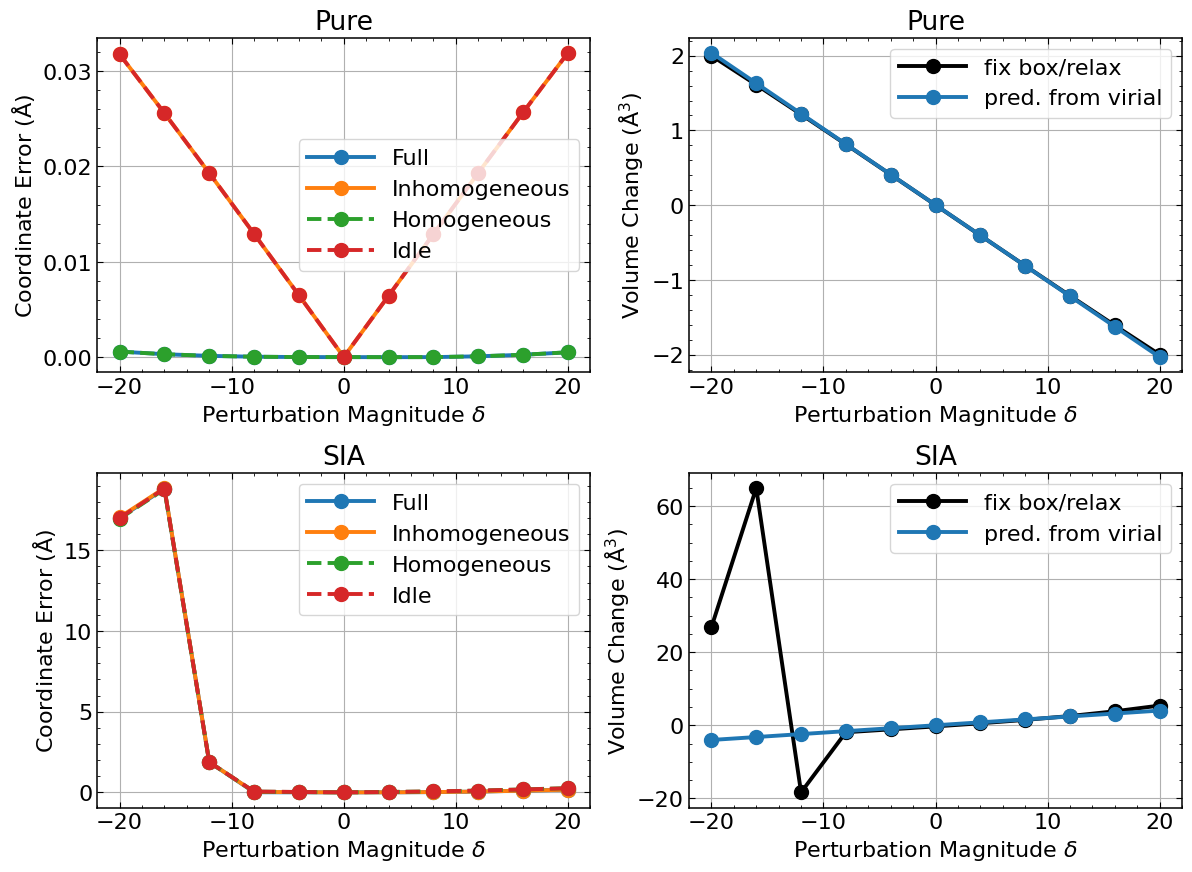

In [55]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plt.subplots_adjust(wspace=0.2, hspace=0.3)

error_axes = [axes[0, 0], axes[1, 0]]
data_lists = [bcc_pure_list, bcc_SIA_list]
title_list = ['Pure', 'SIA']

for i, (data_list, ax) in enumerate(zip(data_lists, error_axes)):

    ax.plot(delta_array,
            [data_list[i]['coord_error_full'] for i in range(ndelta)],
            label='Full', marker='o')
    ax.plot(delta_array,
            [data_list[i]['coord_error_inhom'] for i in range(ndelta)],
            label='Inhomogeneous', marker='o')
    ax.plot(delta_array,
            [data_list[i]['coord_error_hom'] for i in range(ndelta)],
            label='Homogeneous', marker='o', ls='--')
    ax.plot(delta_array,
            [data_list[i]['coord_error_idle'] for i in range(ndelta)],
            label='Idle', ls='--', marker='o')

    ax.set_xlabel('Perturbation Magnitude $\delta$')
    ax.set_ylabel('Coordinate Error ($\mathrm{\AA}$)')
    ax.grid()
    ax.legend()

    ax.set_title(title_list[i])

vol_axes = [axes[0, 1], axes[1, 1]]

for i, (data_list, ax) in enumerate(zip(data_lists, vol_axes)):

    vol0 = data_list[i]['volume0']
    ax.plot(delta_array,
            [data_list[i]['volume_true'] - vol0 for i in range(ndelta)],
            label='fix box/relax', marker='o', c='black')
    ax.plot(delta_array,
            [data_list[i]['volume_pred'] - vol0 for i in range(ndelta)],
            label='pred. from virial', marker='o', c='tab:blue')

    ax.set_xlabel('Perturbation Magnitude $\delta$')
    ax.set_ylabel('Volume Change ($\mathrm{\AA}^3$)')
    ax.grid()
    ax.legend()

    ax.set_title(title_list[i])

plt.show()

In [58]:
def compute_formation_property(Natom_SIA, Natom_pure, SIA_list, pure_list, property_name):

    ndelta = len(SIA_list)
    prop_pure = np.array([SIA_list[i][property_name] for i in range(ndelta)])
    prop_SIA = np.array([pure_list[i][property_name] for i in range(ndelta)])
    #print(f'{prop_vac=} {prop_pure=} {Natom_vac=} {Natom_pure=}')
    prop_formation = prop_SIA - prop_pure * Natom_SIA / Natom_pure

    return prop_formation

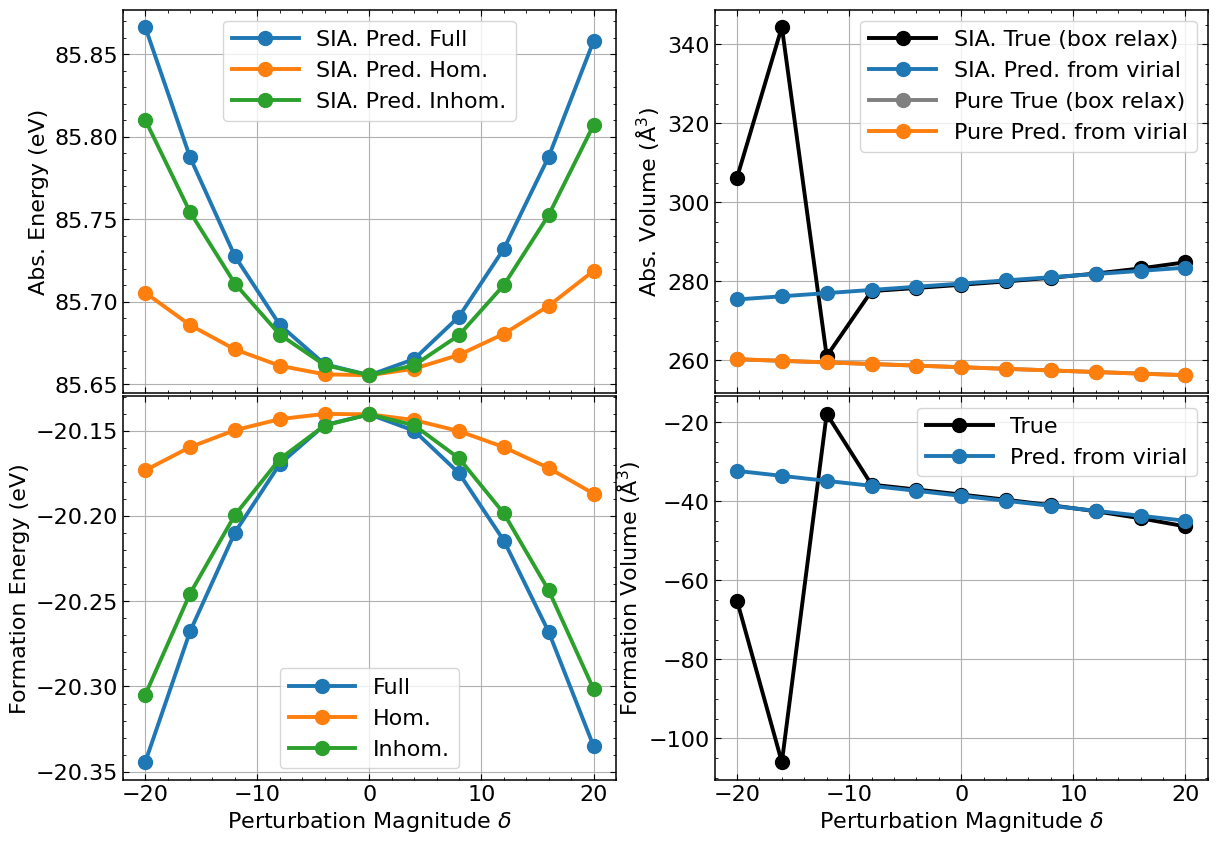

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plt.subplots_adjust(wspace=0.2, hspace=0.01)

# Absolute energy
#plot_energy_true = True
plot_energy_true = False
if plot_energy_true:
    axes[0, 0].plot(delta_array,
                    [bcc_SIA_list[i]['energy_true'] for i in range(ndelta)],
                    label='SIA. True (box relax)', marker='o', c='black')

#plot_energy_true2 = True
plot_energy_true2 = False
if plot_energy_true2:
    axes[0, 0].plot(delta_array,
                    [bcc_SIA_list[i]['energy_true2'] for i in range(ndelta)],
                    label='SIA. True (D @ Theta)', marker='o')

axes[0, 0].plot(delta_array,
                [bcc_SIA_list[i]['energy_full_pred'] for i in range(ndelta)],
                label='SIA. Pred. Full', marker='o')

axes[0, 0].plot(delta_array,
                [bcc_SIA_list[i]['energy_hom_pred'] for i in range(ndelta)],
                label='SIA. Pred. Hom.', marker='o')

axes[0, 0].plot(delta_array,
                [bcc_SIA_list[i]['energy_inhom_pred'] for i in range(ndelta)],
                label='SIA. Pred. Inhom.', marker='o')

#axes[0, 0].set_xlabel('Perturbation Magnitude $\delta$')
# remove tick labels
axes[0, 0].set_xticklabels([])
axes[0, 0].set_ylabel('Abs. Energy (eV)')

# Formation energies
Natom_pure = bcc_pure.Natom
Natom_SIA = bcc_SIA.Natom
E_form_full_pred = compute_formation_property(Natom_SIA, Natom_pure, bcc_SIA_list, bcc_pure_list, 'energy_full_pred')
E_form_hom_pred = compute_formation_property(Natom_SIA, Natom_pure, bcc_SIA_list, bcc_pure_list, 'energy_hom_pred')
E_form_inhom_pred = compute_formation_property(Natom_SIA, Natom_pure, bcc_SIA_list, bcc_pure_list, 'energy_inhom_pred')
E_form_true = compute_formation_property(Natom_SIA, Natom_pure, bcc_SIA_list, bcc_pure_list, 'energy_true')

axes[1, 0].plot(delta_array, E_form_full_pred, label='Full', marker='o')
axes[1, 0].plot(delta_array, E_form_hom_pred, label='Hom.', marker='o')
axes[1, 0].plot(delta_array, E_form_inhom_pred, label='Inhom.', marker='o')
#axes[1, 0].plot(delta_array, E_form_true, label='True', marker='o', c='black')

axes[1, 0].set_xlabel('Perturbation Magnitude $\delta$')
axes[1, 0].set_ylabel('Formation Energy (eV)')

# Absolute volume
axes[0, 1].plot(delta_array,
          [bcc_SIA_list[i]['volume_true'] for i in range(ndelta)],
          label='SIA. True (box relax)', marker='o', c='black')

axes[0, 1].plot(delta_array,
          [bcc_SIA_list[i]['volume_pred'] for i in range(ndelta)],
          label='SIA. Pred. from virial', marker='o')

axes[0, 1].plot(delta_array,
          [bcc_pure_list[i]['volume_true'] for i in range(ndelta)],
          label='Pure True (box relax)', marker='o', c='gray')

axes[0, 1].plot(delta_array,
          [bcc_pure_list[i]['volume_pred'] for i in range(ndelta)],
          label='Pure Pred. from virial', marker='o')


axes[0, 1].set_xticklabels([])
axes[0, 1].set_ylabel('Abs. Volume ($\mathrm{\AA}^3$)')

# Formation volume
vol_form_full_pred = compute_formation_property(Natom_SIA, Natom_pure, bcc_SIA_list, bcc_pure_list, 'volume_pred')
vol_form_true = compute_formation_property(Natom_SIA, Natom_pure, bcc_SIA_list, bcc_pure_list, 'volume_true')

axes[1, 1].plot(delta_array, vol_form_true, label='True', marker='o', c='black')
axes[1, 1].plot(delta_array, vol_form_full_pred, label='Pred. from virial', marker='o')

axes[1, 1].set_xlabel('Perturbation Magnitude $\delta$')
axes[1, 1].set_ylabel('Formation Volume ($\mathrm{\AA}^3$)')

for ax in axes.flatten():
    ax.grid()
    ax.legend()

plt.show()